# 9. Hyperparameter Optimization

- So far, we have only been interested in model parameters such as the weight values of a linear regression. Now, hyperparameters are parameters about the model and the whole process itself such as how many weights should a linear regression have or the learning rate of stochastic gradient descent.

In [7]:
import numpy as np
import pandas as pd

from sklearn import ensemble, metrics, model_selection

df = pd.read_csv('data/mobile_train.csv')
X = df.drop('price_range', axis=1).values
y = df.price_range.values

- As a first approach, we will use **grid search** which runs the learning or training process for every combination of given parameters.

In [10]:
classifier = ensemble.RandomForestClassifier(n_jobs=-1)

param_grid = {
    'n_estimators': [100*(x+1) for x in range(5)],
    'max_depth': [2*x+1 for x in range(6)],
    'criterion': ['gini', 'entropy']
}

model = model_selection.GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1, cv=5)

model.fit(X,y)

print(f'Model best score {model.best_score_}')
print('Best parameter set')

best_parameters = model.best_estimator_.get_params()

for par in sorted(param_grid.keys()):
    print(f'\t{par}: {best_parameters[par]}')

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished


Model best score 0.8869999999999999
Best parameter set
	criterion: entropy
	max_depth: 11
	n_estimators: 500


- This approach checks all the values in `param_grid` and chooses the ones giving best score, in this case accuracy. Another approach is using **random search** which checks parameter combinations randomly as the name suggests. 

In [11]:
classifier = ensemble.RandomForestClassifier(n_jobs=-1)

param_grid = {
    'n_estimators': np.arange(100, 1500, 100),
    'max_depth': np.arange(1,31),
    'criterion': ['gini', 'entropy']
}

model = model_selection.RandomizedSearchCV(estimator=classifier, param_distributions=param_grid, n_iter=20, scoring='accuracy',
                                          verbose=1, n_jobs=-1, cv=5)

model.fit(X,y)

print(f'Model best score {model.best_score_}')
print('Best parameter set')

best_parameters = model.best_estimator_.get_params()

for par in sorted(param_grid.keys()):
    print(f'\t{par}: {best_parameters[par]}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


Model best score 0.8865000000000001
Best parameter set
	criterion: entropy
	max_depth: 13
	n_estimators: 1400


- When dealing with a single model, it's easier to manage hyperparameter optimization process manually. However, feeding the result of a model into another model requires pipeline for better management. Sadly, training data is not available for SVD and SVM optimization example in the book.

- Finally, we use 2 optimization libraries: `scikit-optimize` and `hyperopt`. The first one is bayesian optimization using Gaussian processes and the second one function optimization through a chosen search algorithm. 

In [68]:
from functools import partial
from skopt import gp_minimize, space

def optimize(params, param_names, x, y):
    
    params = dict(zip(param_names, params))
    model = ensemble.RandomForestClassifier(n_jobs=-1, **params)
    
    kf = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []
    
    for idx in kf.split(X=x,y=y):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        
        xtest = x[test_idx]
        ytest = y[test_idx]
        
        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        
        fold_accuracy = metrics.accuracy_score(ytest, preds)
        accuracies.append(fold_accuracy)
        
        return -1 * np.mean(accuracies)
    
param_space = [space.Integer(3,15,name='max_depth'), 
              space.Integer(100,1500, name='n_estimators'),
              space.Categorical(['gini','entropy'], name='criterion'),
              space.Real(0.01,1,prior='uniform', name='max_features')
              ]

param_names = ['max_depth', 'n_estimators', 'criterion', 'max_features']

optimization_function = partial(optimize, param_names=param_names, x=X, y=y)

result = gp_minimize(optimization_function, dimensions=param_space, n_calls=15, n_random_starts=10, verbose=1)
best_parameters = dict(zip(param_names, result))

print(f'\nModel best score {-1*result.fun}')

for i, j in best_parameters.items():
    print(f'\t{i}:{j}')

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.2814
Function value obtained: -0.9100
Current minimum: -0.9100
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.8714
Function value obtained: -0.7900
Current minimum: -0.9100
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.3967
Function value obtained: -0.9150
Current minimum: -0.9150
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.1661
Function value obtained: -0.9000
Current minimum: -0.9150
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.7983
Function value obtained: -0.8300
Current minimum: -0.9150
Iteration No: 6 started. 

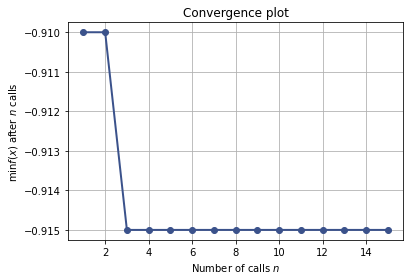

In [69]:
from skopt.plots import plot_convergence
plot_convergence(result)

In [73]:
from functools import partial

from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope

def optimize(params, x, y):
    model = ensemble.RandomForestClassifier(n_jobs=-1, **params)
    kf = model_selection.StratifiedKFold(n_splits=5)

    accuracies = []
    
    for idx in kf.split(X=x,y=y):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        
        xtest = x[test_idx]
        ytest = y[test_idx]
        
        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        
        fold_accuracy = metrics.accuracy_score(ytest, preds)
        accuracies.append(fold_accuracy)
        
        return -1 * np.mean(accuracies)

param_space = {'max_depth': scope.int(hp.quniform('max_depth', 1, 15, 1)),
              'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1500, 1)),
              'criterion': hp.choice('criterion', ['gini', 'entropy']),
              'max_features': hp.uniform('max_features', 0, 1)
              }
optimization_function = partial(optimize, x=X, y=y)

trials = Trials()

hopt = fmin(fn=optimization_function, space=param_space, 
            algo=tpe.suggest, max_evals=15, trials=trials, 
            verbose=True, return_argmin=False)

print(hopt)

100%|██████████| 15/15 [00:30<00:00,  2.06s/trial, best loss: -0.915]
{'criterion': 'entropy', 'max_depth': 15, 'max_features': 0.7088721086225478, 'n_estimators': 1165}
